In [1]:
# %%
import torch
import yaml
from argparse import Namespace
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from model import get_model_and_optim
from data import prepare_nuclear_data
import seaborn as sns
sns.set()

# Download required files from Zenodo
!wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar

!tar -xvf nuclr_files.tar

!rm nuclr_files.tar

Now you should have three folders: `checkpoints/`, `data/` and `plots`. 

In [8]:
# !wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar
# !tar -xvf nuclr_files.tar
# !rm nuclr_files.tar

# Load data

In [2]:
# load args from disk
with open("checkpoints/args.yaml", "r") as f:
    args = yaml.load(f, Loader=yaml.FullLoader)
args = Namespace(**args)
print("Loaded args:", args, "\n")

data = prepare_nuclear_data(args)
print("Loaded Data:", data._fields, "\n")

model, optim = get_model_and_optim(data, args)
model.load_state_dict(torch.load("checkpoints/fig1_model_16.pt"))


Loaded args: Namespace(BATCH_SIZE=1024, CKPT_FREQ=10, CLIP_GRAD=0.001, DEPTH=2, DEV='cuda:1', EPOCHS=50000, HIDDEN_DIM=2048, HOLDOUT='false', LIPSCHITZ='false', LOG_FREQ=1, LR=0.0001, MODEL='baseline', READOUT='identity', ROOT='/work/submit/kitouni/ai-nuclear', SCHED='cosine', SEED=0, SIGMOID_READOUT='false', START_FROM='none', TARGETS_CLASSIFICATION={}, TARGETS_REGRESSION={'binding_semf': 1.0, 'n': 1.0, 'qa': 1.0, 'qbm': 1.0, 'qbm_n': 1.0, 'qec': 1.0, 'radius': 1.0, 'sn': 1.0, 'sp': 1.0, 'z': 1.0}, TMS='remove', TRAIN_FRAC=0.9, WANDB=False, WD=0.01, basedir='/work/submit/kitouni/ai-nuclear/FULL/model_baseline/wd_0.01/lr_0.0001/epochs_50000/trainfrac_0.9/hiddendim_2048/depth_2/seed_0/batchsize_1024/targetsclassification_None/targetsregression_binding_semf:1-z:1-n:1-radius:1-qa:1-qbm:1-qbm_n:1-qec:1-sn:1-sp:1/sched_cosine/lipschitz_false') 

Loaded Data: ('X', 'y', 'vocab_size', 'output_map', 'regression_transformer', 'train_mask', 'val_mask') 



<All keys matched successfully>

PCA: [0.25253105 0.04882849] 



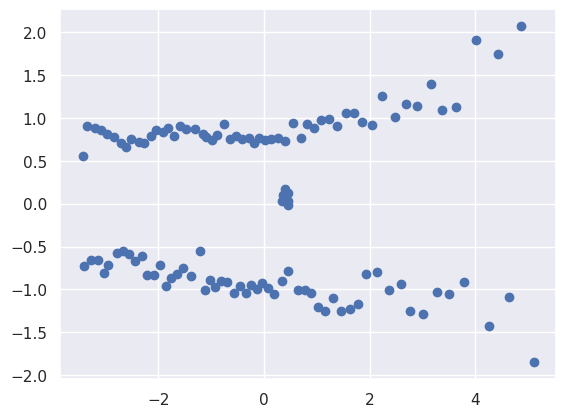

In [3]:
pca = PCA(n_components=2)
embs = pca.fit_transform(model.emb[0].detach().cpu().numpy())
print("PCA:", pca.explained_variance_ratio_, "\n")
plt.plot(embs[:, 0], embs[:, 1], "o")

In [4]:
task_names = list(data.output_map.keys())
magic_numbers = [2, 8, 20, 28, 50, 82, 126][1::]
# Z fixed and move along N see how BE changes.
task_name = "binding_semf"
task_idx = task_names.index(task_name)
protons = 82
max_neutrons = 130
inputs = torch.full((max_neutrons - 9, 3), protons)
inputs[:, 1] = torch.arange(9, max_neutrons)
inputs[:, 2] = task_idx
preds = model(inputs)

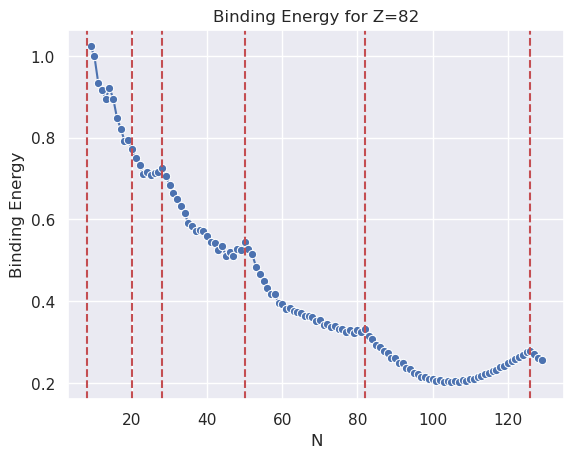

In [5]:
sns.lineplot(x=inputs[:, 1], y=preds[:, task_idx].cpu().detach(), marker='o')
for magic_number in magic_numbers:
    plt.axvline(magic_number, color='r', linestyle='--')
plt.xlabel("N")
plt.ylabel("Binding Energy")
plt.title(f"Binding Energy for Z={protons}")
plt.savefig(f"plots/Z_{protons}_binding_energy.pdf", bbox_inches='tight', pad_inches=0)

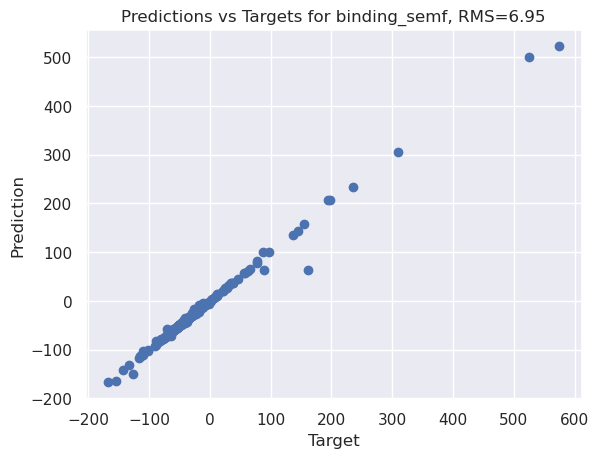

RMS: 6.95


In [6]:
def plot_predictions(task_name, train=True):
    mask = data.train_mask if train else data.val_mask
    task_idx = task_names.index(task_name)
    X_train = data.X[mask]
    scatter = X_train[:, 2].cpu().numpy() == task_idx # get only rows relevant to task

    targets = data.y.view(-1, 10).cpu().numpy()
    targets = data.regression_transformer.inverse_transform(targets)
    targets = targets.flatten()[mask.cpu().numpy()]
    targets = targets[scatter]
    non_nan_targets = ~np.isnan(targets)
    targets = targets[non_nan_targets]


    preds = model(data.X[mask])
    preds = preds.cpu().detach().numpy()
    preds = data.regression_transformer.inverse_transform(preds)[:, task_idx][scatter] 
    preds = preds[non_nan_targets]

    rms = np.sqrt(np.mean((preds - targets)**2))

    plt.plot(targets, preds, "o")
    plt.xlabel("Target")
    plt.ylabel("Prediction")
    plt.title(f"Predictions vs Targets for {task_name}, RMS={rms:.2f}")
    plt.show()
    print(f"RMS: {rms:.2f}")
    
plot_predictions("binding_semf", train=False)

In [7]:
preds

tensor([[ 1.0231,  0.6926,  0.2315,  ...,  2.2372,  1.9384, -0.7942],
        [ 0.9987,  0.6964,  0.2336,  ...,  2.1322,  2.0920, -0.8054],
        [ 0.9349,  0.6848,  0.2282,  ...,  2.1730,  1.9034, -0.7807],
        ...,
        [ 0.2704,  0.7805,  0.6655,  ...,  0.7151,  0.3419,  0.0300],
        [ 0.2621,  0.7790,  0.6711,  ...,  0.6757,  0.4024,  0.0390],
        [ 0.2564,  0.7809,  0.6767,  ...,  0.7079,  0.3388,  0.0454]],
       device='cuda:1', grad_fn=<AddmmBackward0>)